# Project 5 - Vehicle Detection and Tracking

## Introduction

In this project, we apply Computer Vision to the task of vehicle detection and tracking on a video feed.

In [1]:
import os
import math
import cv2
import glob
import zipfile
import scipy
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
from urllib.request import urlretrieve

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [2]:
def get_output_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    return output_dir

## Data download and unpacking

In [3]:
vehicles_file = 'vehicles.zip'
non_vehicles_file = 'non-vehicles.zip'
download_url_base = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/'

In [4]:
def download(url):
    # Get file name
    file = url.rsplit('/', 1)[-1]
    
    # Download
    print('Downloading ' + file + '...')
    if not os.path.isfile(file):
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File already in the filesystem!')
        
download(url = download_url_base + vehicles_file)
download(url = download_url_base + non_vehicles_file)

File already in the filesystem!
File already in the filesystem!


In [5]:
def unzip(file):
    if not os.path.isdir(os.path.splitext(file)[0]):        
        print('Unzipping ' + file + '...')
        with zipfile.ZipFile(file,"r") as zip_ref:
            zip_ref.extractall()
    else:
        print('File ' + file + ' already unpacked!')

unzip(vehicles_file)
unzip(non_vehicles_file)

File vehicles.zip already unpacked!
File non-vehicles.zip already unpacked!


## Data loading

In [6]:
def get_img_shape():
    return (64, 64, 3)

def load_dataset(class_base_folder, class_id):
    # Get filenames recursively
    f_names = glob.glob(class_base_folder + '/**/*.png')
    
    # Declare output arrays
    n_img = len(f_names)
    X = np.zeros((n_img,) + get_img_shape(), dtype = np.uint8)
    y = np.zeros((n_img,), dtype = int)
    
    # Read images and store them in memory
    for i in range(n_img):
        # Note: the input image is PNG, therefore a float32 array between 0.0 and 1.0
        X[i] = scipy.misc.imread(f_names[i])
        y[i] = class_id
        
    return X, y

print('Loading datasets...')
X_v, y_v = load_dataset('vehicles', 1)
X_nv, y_nv = load_dataset('non-vehicles', 0)
print('Done...')

Loading datasets...
Done...


In [7]:
print('Vehicle training data: ', X_v.shape, y_v.shape)
print('Non-vehicle training data: ', X_nv.shape, y_nv.shape)

X = np.concatenate((X_v, X_nv))
y = np.concatenate((y_v, y_nv))

print('Combined dataset: ', X.shape, y.shape)
print(np.amin(X), np.amax(X))

Vehicle training data:  (8792, 64, 64, 3) (8792,)
Non-vehicle training data:  (9666, 64, 64, 3) (9666,)
Combined dataset:  (18458, 64, 64, 3) (18458,)
0 255


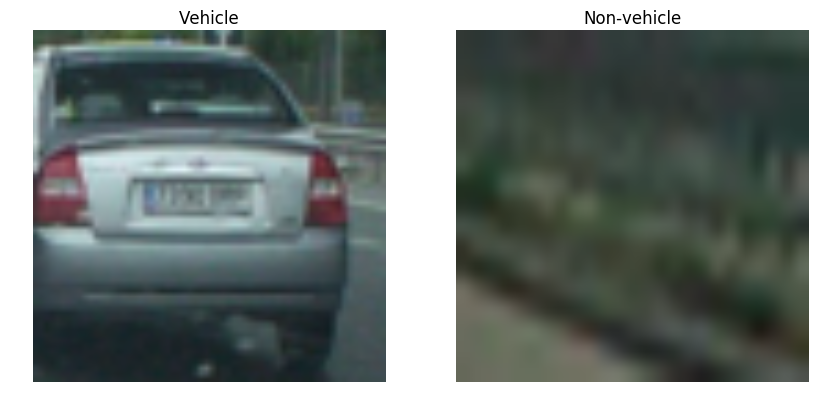

In [8]:
plt.subplot(1,2,1);
plt.imshow(X_v[0]);
plt.title('Vehicle');
plt.axis('off');
plt.subplot(1,2,2);
plt.imshow(X_nv[0]);
plt.title('Non-vehicle');
plt.axis('off');

## Data preprocessing

In [9]:
def rgb_to_ycrcb(X):
    for x in X:
        x = cv2.cvtColor(x, cv2.COLOR_RGB2YCrCb)
X = rgb_to_ycrcb(X)

## HOG feature extraction

## Classifier Design

## Training

## Sliding Window Search

## Single Image pipeline

## Video pipeline

## Test on images

## Test on video